In [1]:
import numpy as np
import cv2 as cv
import time
import os
import copy

In [2]:
path = '/home/fizzer/ros_ws/src/controller/node/'
img_folder = "pictures"
img_name = "p_right_close.png"
full_path = os.path.join(path, img_folder, img_name)

img = cv.imread(full_path,cv.IMREAD_COLOR)
# img = cv.medianBlur(img,5)
# Convert BGR to HSV
# hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

# # isolates blue
# uh = 125
# us = 255
# uv = 255
# lh = 118
# ls = 40
# lv = 40

# # isolates partial rectangle around P2 and plate
# uh = 122
# us = 117
# uv = 105
# lh = 114
# ls = 000
# lv = 89

# used with blur - general
uh = 176
us = 11
uv = 98 # 117
lh = 115
ls = 0
lv = 89


mb = 13
img_blur = cv.medianBlur(img,mb)
# img = cv.GaussianBlur(img,(5,5),0)
hsv = cv.cvtColor(img_blur, cv.COLOR_BGR2HSV)


lower_hsv = np.array([lh,ls,lv])
upper_hsv = np.array([uh,us,uv])

# Threshold the HSV image to get only blue colors
# mask = cv.inRange(hsv, lower_hsv, upper_hsv) # if in range, 1, else, 0
window_name = "HSV Calibrator"
cv.namedWindow(window_name)

def nothing(x):
    print("Trackbar value: " + str(x))
    pass

# create trackbars for Upper HSV
cv.createTrackbar('UpperH',window_name,0,255,nothing)
cv.setTrackbarPos('UpperH',window_name, uh)

cv.createTrackbar('UpperS',window_name,0,255,nothing)
cv.setTrackbarPos('UpperS',window_name, us)

cv.createTrackbar('UpperV',window_name,0,255,nothing)
cv.setTrackbarPos('UpperV',window_name, uv)

# create trackbars for Lower HSV
cv.createTrackbar('LowerH',window_name,0,255,nothing)
cv.setTrackbarPos('LowerH',window_name, lh)

cv.createTrackbar('LowerS',window_name,0,255,nothing)
cv.setTrackbarPos('LowerS',window_name, ls)

cv.createTrackbar('LowerV',window_name,0,255,nothing)
cv.setTrackbarPos('LowerV',window_name, lv)

font = cv.FONT_HERSHEY_SIMPLEX

while(1):
    # Threshold the HSV image to get only blue colors
    mask = cv.inRange(hsv, lower_hsv, upper_hsv)
    
    # dilate, then do edge detection
    kernel = np.ones((17,17),np.uint8)
    dilation = cv.dilate(mask,kernel,iterations=1) # https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html
    edged = cv.Canny(dilation,75,200)
    cv.imshow("dilated edges", edged)

    # https://medium.com/analytics-vidhya/opencv-findcontours-detailed-guide-692ee19eeb18
    contours_edge, _ = cv.findContours(edged, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours_edge = sorted(contours_edge,key=cv.contourArea,reverse=True) # largest to smallest contours
    largest_contour = contours_edge[0]
    # TODO: probably want the contour to have at least a certain size before we accept it as "valid"
    x,y,width,height = cv.boundingRect(largest_contour) # coords of largest contour
    plate = img[y:y+height,x:x+width] # isolate plate
    cv.imshow("plate",plate)
    
    # TODO: perspective transformation
    # https://arccoder.medium.com/straighten-an-image-of-a-page-using-opencv-313182404b06
    # in_pts = 
    # out_pts = [[0,0],[width,0],[width,height],[0,height]]

    # M = cv.getPerspectiveTransform(np.float32(),np.float32())
    # perspective_transform = cv.warpPerspective(plate,M,(width,height))

    img_copy = copy.deepcopy(img)
    cv.drawContours(img_copy, [largest_contour], -1, (0,255,0),2)
    cv.imshow("contours",img_copy)

    # blue hsv mask
    uh_plate = 125
    us_plate = 255
    uv_plate = 255
    lh_plate = 118
    ls_plate = 40
    lv_plate = 40
    lower_hsv_plate = np.array([lh_plate,ls_plate,lv_plate])
    upper_hsv_plate = np.array([uh_plate,us_plate,uv_plate])


    # mask
    hsv_plate = cv.cvtColor(plate, cv.COLOR_BGR2HSV)
    mask_plate = cv.inRange(hsv_plate,lower_hsv_plate,upper_hsv_plate)
    cv.imshow("mask plate",mask_plate)

    # erode
    kernel_erode = np.ones((2,2),np.uint8)
    mask_erode = cv.erode(mask_plate,kernel_erode,iterations=1)
    cv.imshow("erode plate",mask_erode)

    # contours
    contours_plate, _ = cv.findContours(mask_erode,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    contours_plate = sorted(contours_plate,key=cv.contourArea,reverse=True)
    plate_copy = copy.deepcopy(plate)
    cv.drawContours(plate_copy,contours_plate,-1,(0,255,0),1)
    cv.imshow("contours plate",plate_copy)

    # contour bounding rectangles

    plate_rect_display = copy.deepcopy(plate)

    bounding_rects = []
    for cntr in contours_plate:
        x,y,width,height = cv.boundingRect(cntr)
        bounding_rects.append([[x,y,width,height],(x+width * y+height)]) #[[[x,y,w,h],area], [[x,y,w,h],area], [[x,y,w,h],area]]]
        
    areas = np.asarray([bounding_rects[i][1] for i in range(len(bounding_rects))])
    max_area_indicies = list(reversed(areas.argsort())) # index of max area is 0th element, descending
    char_bounding_rects = []
    for k in range(4): #get 4-largest area contours
        rect_idx = max_area_indicies[k]
        x_i = bounding_rects[rect_idx][0][0]
        y_i = bounding_rects[rect_idx][0][1]
        width_i = bounding_rects[rect_idx][0][2]
        height_i = bounding_rects[rect_idx][0][3]
        char_bounding_rects.append([x_i,y_i,width_i,height_i])
        cv.rectangle(plate_rect_display,(x_i,y_i+height_i),(x_i+width_i,y_i),(0,0,255),1) # (top left), (bottom right)
    
    char_bounding_rects.sort(key=lambda char_bounding_rects : char_bounding_rects[0]) # sort based on x value, lowest = leftmost = 0th
    cv.imshow("rectangle contours",plate_rect_display)

    for c in range(len(char_bounding_rects)):
        x_c = char_bounding_rects[c][0]
        y_c = char_bounding_rects[c][1]
        width_c = char_bounding_rects[c][2]
        height_c = char_bounding_rects[c][3]
        padding = 1 # additional pixels to include, for if we crop in too much
        char = plate[y_c-padding:y_c+height_c+padding,x_c-padding:x_c+width_c+padding] # cropped char from plate
    
    cv.putText(mask,'Lower HSV: [' + str(lh) +',' + str(ls) + ',' + str(lv) + ']', (10,30), font, 0.5, (200,255,155), 1, cv.LINE_AA)
    cv.putText(mask,'Upper HSV: [' + str(uh) +',' + str(us) + ',' + str(uv) + ']', (10,60), font, 0.5, (200,255,155), 1, cv.LINE_AA)

    cv.imshow(window_name,mask)

    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
    # get current positions of Upper HSV trackbars
    uh = cv.getTrackbarPos('UpperH',window_name)
    us = cv.getTrackbarPos('UpperS',window_name)
    uv = cv.getTrackbarPos('UpperV',window_name)
    upper_blue = np.array([uh,us,uv])
    # get current positions of Lower HSCV trackbars
    lh = cv.getTrackbarPos('LowerH',window_name)
    ls = cv.getTrackbarPos('LowerS',window_name)
    lv = cv.getTrackbarPos('LowerV',window_name)

    upper_hsv = np.array([uh,us,uv])
    lower_hsv = np.array([lh,ls,lv])

    time.sleep(.1)

cv.destroyAllWindows()

Trackbar value: 176
Trackbar value: 11
Trackbar value: 98
Trackbar value: 115
Trackbar value: 89


KeyboardInterrupt: 

In [ ]:
char_bounding_rects
char_bounding_rects.sort(key=lambda char_bounding_rects : char_bounding_rects[0]) # sort based on x value, lowest = leftmost = 0th
print(char_bounding_rects)

[[20, 18, 18, 11], [41, 18, 22, 12], [88, 20, 21, 11], [110, 21, 22, 11]]


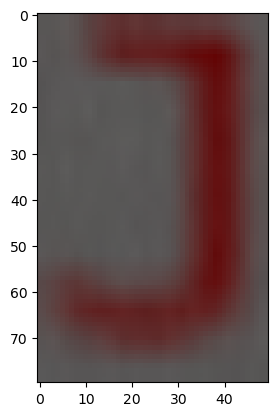

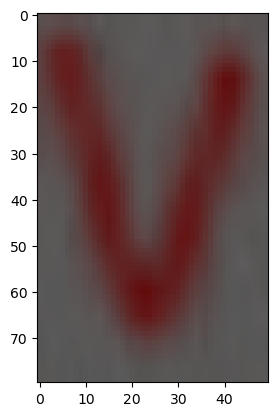

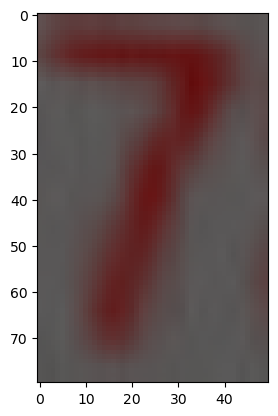

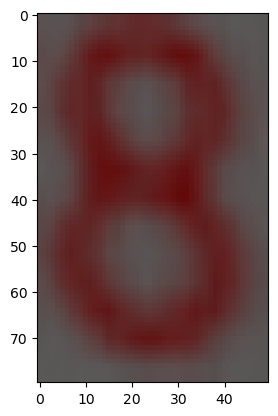

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

chars = []

for c in range(len(char_bounding_rects)):
    x_c = char_bounding_rects[c][0]
    y_c = char_bounding_rects[c][1]
    width_c = char_bounding_rects[c][2]
    height_c = char_bounding_rects[c][3]
    padding = 1
    char = plate[y_c-padding:y_c+height_c+padding,x_c-padding:x_c+width_c+padding] # cropped char from plate
    chars.append(char)
    plt.imshow(cv.resize(char, (50,80)))
    plt.show()

In [ ]:
from tensorflow import keras

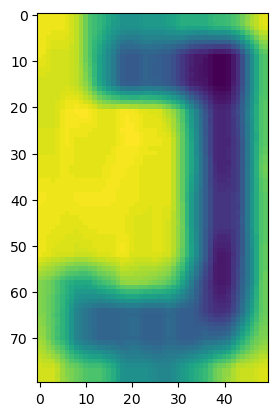

1/1 [==============================] - 0s 69ms/step


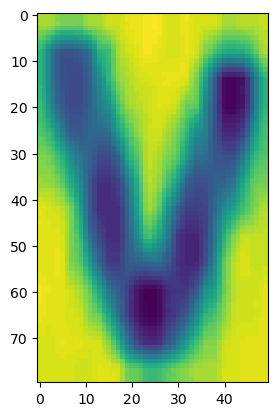

1/1 [==============================] - 0s 15ms/step


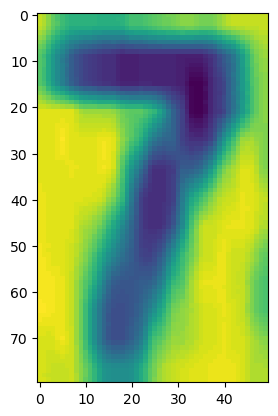

1/1 [==============================] - 0s 14ms/step


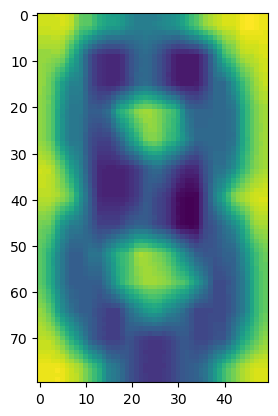

1/1 [==============================] - 0s 16ms/step


In [ ]:
conv_model = keras.models.load_model('/home/fizzer/ros_ws/src/controller/node/conv_model_74k')
predictions = []
for k in chars:
    kernel = np.ones((2,2),np.uint8)
    char_img = cv.erode(cv.cvtColor(k,cv.COLOR_BGR2GRAY),kernel,iterations=1) # helps "sharpen" letters, can experment with kernel size
    char_img_resized = cv.resize(char_img, (50,80))
    plt.imshow(char_img_resized)
    plt.show()
    prediction = [conv_model.predict(np.expand_dims(char_img_resized,axis=0))[0]]
    predictions.append(prediction)


In [ ]:
max_predictions = [np.argmax(i) for i in predictions]
max_predictions

[19, 31, 7, 8]